### ETAS: NorCal, General Purpose


In [2]:
#
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import datetime as dtm
import matplotlib.dates as mpd
import pytz
tzutc = pytz.timezone('UTC')

#import operator
import math
import random
import numpy
import scipy
import scipy.optimize as spo
from scipy import interpolate
import itertools
import sys
#import scipy.optimize as spo
import os
import operator
#from PIL import Image as ipp
import multiprocessing as mpp
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import json
import pickle
#

import geopy.distance
#from geopy.distance import vincenty
#from geopy.distance import great_circle
#
#import shapely.geometry as sgp
#
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from geographiclib.geodesic import Geodesic as ggp
#

#import ANSStools as atp
from yodiipy import ANSStools as atp
#

import contours2kml
import globalETAS as gep

import global_etas_auto as ggep

from eq_params import *
#
from nepal_figs import *
import optimizers
#
import random
import geopy

failed while loading urllib and/or urllib. maybe python 3.x?


/home/myoder/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
# event was some time on the 24th or maybe late the 23rd. this, plus defaults, should find the event:
#to_dt = dtm.datetime(2016,8,25, tzinfo=pytz.timezone('UTC'))
to_dt = dtm.datetime.now(pytz.timezone('UTC'))
#
Lr_factor = 10.
# define these from the t_now in the actual etas object, in the event that we load it from pickle,
#  rather than calc it here.
#f_path = '/home/myoder/Dropbox/Research/etas/italy_2016_10/etas_{}'.format(to_dt)
#f_root = 'etas_2016'
#

t0 = dtm.datetime.now(pytz.timezone('UTC'))
t_ms = t0
to_dt
#
# sacramento:
lat0 = 38.5816
lon0 = -121.4944
ll_sacramento = (lon0, lat0)

#m0 = 7.8

d_lat=5.
d_lon=5.
#
lats = [lat0-d_lat, lat0+d_lat]
lons = [lon0-d_lon, lon0+d_lon]
#to_dt = t0-dtm.timedelta(hours=2)
#to_dt = dtm.datetime.now(pytz.utc)
#
#etas = ggep.auto_etas(to_dt=to_dt, Lr_factor=Lr_factor, dt_0=5)
#italy_prams = {'do_recarray': True, 'D_fract': 1.5,
#                't_0':dtm.datetime(1990, 1, 1, 0, 0, tzinfo=pytz.timezone('UTC')),
#                't_now':to_dt, 
#                'lats': [42.,43.5], 'p': 1.1, 'b1': 1.0, 'mc': 2.5, 'q': 1.5,
#                'lons': [12.,15.], 'dmstar': 1.0, 'b2': 1.5, 'd_tau': 2.28,
#                'incat': None, 'fit_factor': 2.0, 'd_lambda': 1.76}
eq_prams_1 = {'do_recarray': True, 'D_fract': 1.5,
               't_0':dtm.datetime(1990, 1, 1, 0, 0, tzinfo=pytz.timezone('UTC')),
               't_now':dtm.datetime(2007,1,1, tzinfo=pytz.timezone('UTC')), 
               'lats': lats, 'p_cat': 1.1, 'b1': 1.0, 'mc': 1., 'q_cat': 1.5,
               'p_etas':0., 'q_etas':1.5, 'cat_len':None,
               'lons': lons, 'dmstar': 1.0, 'b2': 1.5, 'd_tau': 2.28,
               'incat': None, 'fit_factor': 2.0, 'd_lambda': 1.76, 'etas_range_padding':1.5,
            'etas_range_factor':30.0, 'ab_ratio_expon':.25 }
#
eq_prams_2 = {'do_recarray': True, 'D_fract': 1.5,
               't_0':dtm.datetime(2007,1,1, tzinfo=pytz.timezone('UTC')),
               't_now':dtm.datetime(2017,1,1, tzinfo=pytz.timezone('UTC')), 
               'lats': lats, 'p_cat': 1.1, 'b1': 1.0, 'mc': 1., 'q_cat': 1.5,
               'p_etas':0., 'q_etas':1.5, 'cat_len':None,
               'lons': lons, 'dmstar': 1.0, 'b2': 1.5, 'd_tau': 2.28,
               'incat': None, 'fit_factor': 2.0, 'd_lambda': 1.76, 'etas_range_padding':1.5,
            'etas_range_factor':30.0, 'ab_ratio_expon':.25 }
#
# for dev, etc. make this easier on ourselves:
eq_prams_1.update({'mc':3.0, 'd_lat':.25, 'd_lon':.25})
eq_prams_2.update({'mc':3.0, 'd_lat':.25, 'd_lon':.25})


In [5]:
# let's add a preliminary map...
class Preliminary_Map(object):
    def __init__(self, lats, lons):
        pass

In [ ]:
n_cpu = 2*mpp.cpu_count()
#n_cpu=5
etas_1 = gep.ETAS_mpp(n_cpu=n_cpu, **eq_prams_1)
etas_2 = gep.ETAS_mpp(n_cpu=n_cpu, **eq_prams_2)

#
# we've run this; we can reload it from pickle:
#with open('data/etas_201610.pkl', 'rb') as fin:
#    etas = pickle.load(fin)
#
event_name = 'NorCal_general_subtraction'
f_path = '/home/myoder/Dropbox/Research/etas/{}/etas_{}'.format(event_name, etas_1.t_now)
f_root_1 = 'etas_{}_pre'.format(event_name)
f_root_2 = 'etas_{}_post'.format(event_name)

### Subtract and compare:
we have time independent ETAS for a long training period and recent activity.

we're going to look at a few metrics to estimate anomalous activity:

1. we'll typically be looking at "forecast" data that are normalized somehow, probably as a rate (so divide each value by the length of the catalog).
2. First, we just want to subtract. Which areas were hotter/cooler than the longer term forecast. (This is basically PI, so we should look back at some of KT's papers to extract the subtlties of PI).
3. What about our GS ROC? Maybe plot the geospatial "skill" field?


/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


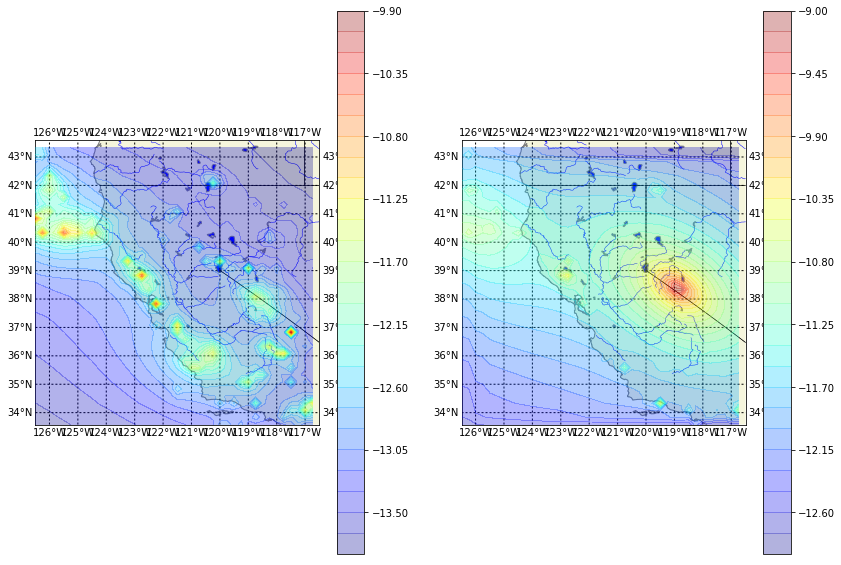

In [12]:
plt.figure(figsize=(14,10))
plt.clf()
ax1 = plt.subplot('121')
ax2 = plt.subplot('122')
#
etas_1.make_etas_contour_map(n_contours=25, fignum=0, map_resolution='f', alpha=.3, ax=ax1)
etas_2.make_etas_contour_map(n_contours=25, fignum=0, map_resolution='f', alpha=.3, ax=ax2)


#diffs = etas_1.

shape:  (40, 40) 1600


/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


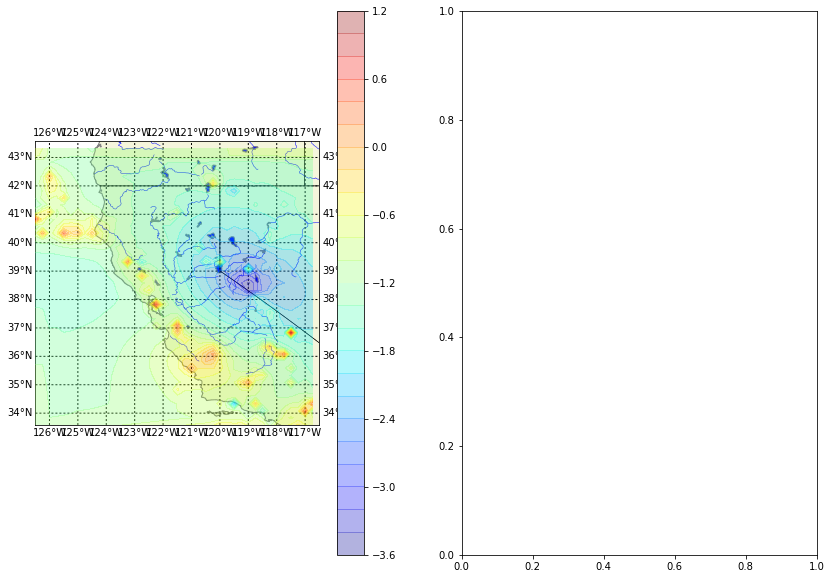

In [13]:
def roc_skill(a,b):
    # something like this (check it)...
    return min(a,b) - min((b-a),0.)
diffs = numpy.log10(etas_1.ETAS_array['z']) - numpy.log10(etas_2.ETAS_array['z'])
diffs.shape = etas_1.lattice_sites.shape
print('shape: ', numpy.shape(etas_1.lattice_sites), len(etas_2.ETAS_array['z']))
#
plt.figure(figsize=(14,10))
plt.clf()
ax1 = plt.subplot('121')
ax2 = plt.subplot('122')
#
etas_1.make_etas_contour_map(n_contours=25, fignum=0, map_resolution='f', alpha=.3, ax=ax1, Z=diffs)

ms:  (datetime.datetime(2016, 12, 28, 8, 22, 12, 210000), 38.3904, -118.8972, 5.63, 12.18, 736326.3487524305, 11.350108156723149, 17.5990690454493, 0.01117596796132656, 3.4276778654645046, 1.482310416954447, 0.22537517862439763, 1.0, 1.1, 1.5, array([ 3.65812137,  9.91435261]), array([[-0.76643887,  0.64231725],
       [-0.64231725, -0.76643887]]), 35.0) -118.8972 38.3904
tt:  736472.8350680827 2012-06-10T04:33:58.920000 <class 'numpy.datetime64'>


/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: ax

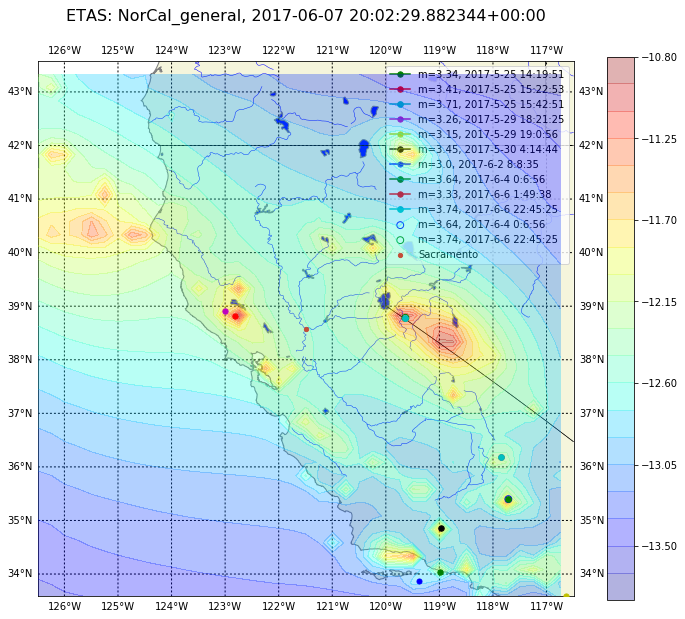

In [15]:

fg=plt.figure(0, figsize=(12,10))
ax=plt.gca()
etas.make_etas_contour_map(n_contours=25, fignum=0, map_resolution='f', alpha=.3, ax=ax)
#
#mainshock = sorted(etas.catalog, key=lambda rw: rw['mag'])[-1]
#print('mainshock: ', mainshock)
# get mainshock. it's an m>6 event in the last week or so... this is subjective.
# if we just look for the biggest event, we get the L'Aquila event, so we'll need to be more creative...
# or just specify it.

mainshock = etas.catalog[-1]
for j,eq in enumerate(reversed(etas.catalog)):
    #print('*** ', pytz.utc.localize(eq['event_date'].astype(dtm.datetime)))
    if pytz.utc.localize(eq['event_date'].astype(dtm.datetime))<etas.t_now-dtm.timedelta(days=180): break
    if eq['mag']>mainshock['mag']:
        mainshock = eq
        #
    #
#
print('ms: ', mainshock, mainshock['lon'], mainshock['lat'])
x,y = etas.cm(mainshock['lon'], mainshock['lat'])
#
#print('mm: ', max(etas.catalog['mag']))
#
# let's get everything m>6 in the last 6 months?
#m6s = [rw for rw in etas.catalog if rw['mag'] >= 5.5 
#       and pytz.utc.localize(rw['event_date'].astype(dtm.datetime))>to_dt-dtm.timedelta(days=180)]
m6s = [rw for rw in etas.catalog if rw['mag'] >= 3.5 
       and pytz.utc.localize(rw['event_date'].astype(dtm.datetime))>to_dt-dtm.timedelta(days=5)]

#
# plot mainshock:
dt = mainshock['event_date'].astype(dtm.datetime)
dt=t0
dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
#etas.cm.plot([x], [y], latlon=False, marker='*', color='r', ms=16, zorder=11,
#                   label='m={}, {}'.format(mainshock['mag'], dt_str))
#etas.cm.plot([lon0], [lat0], latlon=False, marker='*', color='r', ms=16, zorder=11,
#                   label='m={}, {}'.format(m0, dt_str))

ax.set_title('ETAS: {}, {}\n\n'.format(event_name, etas.t_now), size=16)
for j,m6 in enumerate(m6s):
    clr = colors_[j%len(colors_)]
    #
    dt = m6['event_date'].astype(dtm.datetime)
    dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
    etas.cm.scatter(m6['lon'], m6['lat'], s=3*(m6['mag']+12.), edgecolors=clr, 
                          c='none', marker='o', zorder=11, label='m={}, {}'.format(m6['mag'], dt_str))

x,y = etas.cm(*ll_sacramento)
etas.cm.scatter([x],[y], marker='o', s=18, edgecolors='r', c='r',
                    label='Sacramento')
t_cat = mpd.date2num(etas.t_now-dtm.timedelta(days=15))
print('tt: ', t_cat, etas.catalog['event_date'][0], type(etas.catalog['event_date'][0]))
k=0
for j,rw in enumerate(etas.catalog):
    if mpd.date2num(rw['event_date'].astype(dtm.datetime))<t_cat: continue
    k+=1
    clr = colors_[k%len(colors_)]
    #
    dt = rw['event_date'].astype(dtm.datetime)
    dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
    #etas.cm.scatter(rw['lon'],rw['lat'], s=3*(rw['mag']+12.), edgecolors=clr, 
    #                      c='none', marker='o', zorder=11, label='m={}, {}'.format(rw['mag'], dt_str))
    etas.cm.plot(rw['lon'],rw['lat'], ms=1.*(rw['mag']+2.), color=clr, 
                          marker='o', zorder=11, label='m={}, {}'.format(rw['mag'], dt_str), latlon=True)
    
    #
plt.gca().legend()
#print(etas.catalog[-10:])

In [8]:
print(['{},{}\n'.format(rw['event_date'], rw['mag'] ) for rw in etas.catalog if rw['mag'] >= 5.5])
len(['{},{}\n'.format(rw['event_date'], rw['mag'] ) for rw in etas.catalog if rw['mag'] >= 5.5
     and rw['event_date'].astype(dtm.datetime)>dtm.datetime(2016,10,20)])



['2013-05-24T03:47:08.180000,5.69\n', '2014-03-10T05:18:13.430000,6.8\n', '2014-08-24T10:20:44.070000,6.02\n', '2015-01-28T21:08:53.710000,5.72\n', '2016-09-03T03:27:58.090000,5.6\n', '2016-12-08T14:49:45.910000,6.6\n', '2016-12-28T08:18:00.610000,5.63\n', '2016-12-28T08:22:12.210000,5.63\n', '2016-12-28T09:13:47.240000,5.5\n']


4

In [9]:
## hey, pickling works with the new ETAS objects (or at least it appears to...):
# with open('data/etas_201610.pkl', 'wb') as fpkl:
#     pickle.dump( etas, fpkl)    
#
#with open('data/etas_201610.pkl', 'rb') as fin:
#    etas2 = pickle.load(fin)
#
#print(etas2.catalog[0:5])
# TODO: we want the datetime part of the filename to come from the etas object itself, for purposes of
# integrity. BUT, we want this script to be a bit more portable, so we should replace all the etas
# references/object name to just 'etas'
#
etas.export_kml(os.path.join(f_path, '{}_{}.kml'.format(f_root, str(etas.t_now).replace(' ', '_'))))
etas.export_xyz(os.path.join(f_path, '{}_{}.xyz'.format(f_root, str(etas.t_now).replace(' ', '_'))))
fg.savefig(os.path.join(f_path, '{}_{}.png'.format(f_root, str(etas.t_now).replace(' ', '_'))))
#
# so this worked, once upon a time, but breaks maybe when the script does not run cleanly all the way through?
#with open (os.path.join(f_path, '{}_{}.pkl'.format(f_root, str(etas.t_now).replace(' ', '_'))), 'wb') as fpkl:
#    pickle.dump(etas, fpkl)


kml bottom, top:  0 20


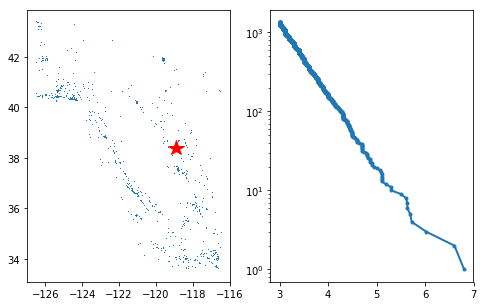

In [10]:
plt.figure(figsize=(8,5))
plt.clf()
ax1=plt.subplot('121')
ax2=plt.subplot('122')
ax1.plot(etas.catalog['lon'], etas.catalog['lat'], ',')
ax1.plot([mainshock['lon']], [mainshock['lat']], marker='*', color='r', ms=16, zorder=11)
#
ax2.plot([m for m in reversed(sorted(etas.catalog['mag']))], numpy.arange(1,len(etas.catalog)+1),
         '.-', lw=2.)
ax2.set_yscale('log')

In [11]:
#print(etas.mc, etas.mc_etas)

In [12]:
# plot a cross-section of ETAS. let's get smart about this and do a PCA on the xyz field...
#
#plt.figure()
##my_xy = [[x,y,z] for x,y in zip(etas.catalog['lon'], etas['lat']) if x>=42.25 and x<=42.75]
#my_xyz = [[x,y,z] for x,y,z in etas.ETAS_array if y>=42.25 and y<=42.75]
#plt.figure(figsize=(8,6))
#plt.plot([x for x,y,z in my_xyz ], [z for x,y,z in my_xyz], '.')

In [13]:
mycat = atp.catfromANSS(lon=lons, lat=lats, minMag=2.5,
                        dates0=[dtm.datetime(2005,1,1, tzinfo=tzutc), None], Nmax=None, fout=None, rec_array=True)


data handle fetched...
 no file.


In [14]:
print(mycat.dtype)

(numpy.record, [('event_date', '<M8[us]'), ('lat', '<f8'), ('lon', '<f8'), ('mag', '<f8'), ('depth', '<f8'), ('event_date_float', '<f8')])
